# Definición de bordes por medio de operadores morfológicos

La dilatación y la erosión son las dos operaciones básicas en morfología. Se realizan diversas operaciones morfológicas combinando estas dos operaciones de manera adecuada. La dilatación expande los objetos en una imagen añadiendo píxeles en las fronteras, mientras que la erosión elimina los píxeles en las fronteras y encoge los objetos.

## Librerías a usar

In [1]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

## Imágenes de prueba

In [2]:
image_unir_color = cv.imread('im/unir-1.jpg')
image_unir_grays = cv.imread('im/unir-1.jpg', cv.IMREAD_GRAYSCALE)

In [3]:
# Imagen en binario
thresh = 128 #La mitad de bits
image_unir_bin = cv.threshold(image_unir_grays, thresh, 255, cv.THRESH_BINARY)[1]

## Definición del elemento estructural

El elemento estructural es similar a la respuesta del impulso en la convolución. Su tamaño y forma variará según el objetivo del filtro debido a que el objetivo del elemento estructural es superponerlo al píxel de entrada que se procesa.

Para este trabajo se ha definido un elemento estructural cuadrado de tamaño 3x3, sin embargo también se dejan otras posibilidades con el propósito de prueba.

In [4]:
def mask(n):
    '''Define a nxn mask.
    Useful for a quick filter
    '''
    mask = np.ones((n,n), np.uint8)
    return mask

kernel_3 = mask(3)
kernel_5 = mask(5)
kernel_7 = mask(7)

kernel = kernel_3

im = image_unir_grays

erosion = cv.erode(im, kernel, iterations=1)
dilation = cv.dilate(im, kernel, iterations=1)
cv.imwrite('out/erosion.jpg', erosion)
cv.imwrite('out/dilation.jpg', dilation)

## Pixeles de relleno (padding)

La siguiente función, padding, permitirá trabajar los límites de la imagen adecuadamente y al mismo tiempo considera el tamaño del elemento estructural.

In [5]:
def padding(originalImg, padSize):
    padImg = np.zeros((rows+2*padSize, columns+2*padSize), dtype=np.uint8)
    # recortando
    padImg[padSize:rows+padSize, padSize:columns+padSize] = originalImg
    return padImg

## Implementación

A continuación se definen las dos operaciones morfológicas básicas: Erosión y dilatación. El código está debidamente comentado.

In [5]:
def Erosion(padImg, kernel, size):
    output = np.zeros((rows, columns), dtype=np.uint8)
    for i in range(0, rows):
        for j in range(0, columns):
            # recortando
            portion = padImg[i:i+size, j:j+size]
            # se suma el elemento estructural y la ventana
            portion1 = portion.flatten()
            portion2 = kernel.flatten()
            p1 = (np.sum(portion1))
            p2 = (np.sum(portion2))*255
            # la condicional para que no revase el limite
            if p1 == p2:
                output[i, j] = 255
            else:
                output[i, j] = np.min(portion1)
    return output
def Dilatacion(padImg, size):
    output = np.zeros((rows, columns), dtype=np.uint8)
    for i in range(0, rows):
        for j in range(0, columns):
            # recortando
            portion = padImg[i:i+size, j:j+size]
            portion1 = portion.flatten()
            # la condicional para que no revase el limite
            if 255 in portion1:
                output[i, j] = 255
            else:
                output[i, j] = np.max(portion1)
    return output

## Aplicación

Ahora se establecerá el codigo necesario para obtener el borde de una imagen previamente definida. Para ello primero aplicamos los operadores morfológicos sobre la imagen, el resultado serán otras dos imágenes con los pixeles expandidos (dilatación) o eliminados (erosión), tal cual se esperaba.

In [6]:
# Esta es la dimensión del kernel original
size = 9
# Tamaño del padding
p_size = size // 2
# Es posible variar entre imágenes
im = image_unir_grays
# se obtiene el padding inicial
padImg = padding(im, p_size)

In [7]:
#aplicamos dilatacion
dilation = Dilatacion(padImg, size)
cv.imwrite('out/dilation.jpg', dilation)
#aplicamos erosion
erosion = Erosion(padImg, kernel, size)
cv.imwrite('out/erosion.jpg',erosion)

True

Para obtener el aproximado de los bordes es necesario es necesario restar los valores de dos imágenes, en este caso se han usado tres casos:

- Dilatación menos erosión por medio de la función `subtract()` de OpenCV.
- Imagen original menos erosión por medio de la función `substract()` de OpenCV.
- Dilatación menos erosión por medio de la resta directa de matrices.

In [8]:
border_d_e = cv.subtract(dilation, erosion)
border_i_e = cv.subtract(im, erosion)
border_res = dilation - erosion
cv.imwrite('out/border_d_e.jpg', border_d_e)
cv.imwrite('out/border_i_e.jpg', border_i_e)
cv.imwrite('out/border_res.jpg', border_res)

True

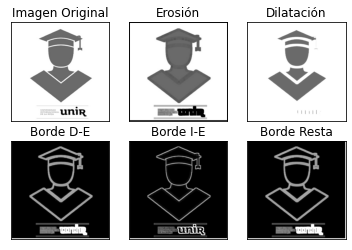

In [9]:
im = cv.cvtColor(im, cv.COLOR_BGR2RGB)
erosion = cv.cvtColor(erosion, cv.COLOR_BGR2RGB)
dilation = cv.cvtColor(dilation, cv.COLOR_BGR2RGB)
border_d_e = cv.cvtColor(border_d_e, cv.COLOR_BGR2RGB)
border_i_e = cv.cvtColor(border_i_e, cv.COLOR_BGR2RGB)
border_res = cv.cvtColor(border_res, cv.COLOR_BGR2RGB)
plt.subplot(231)
plt.imshow(im)
plt.title('Imagen Original'), plt.xticks([]), plt.yticks([])
plt.subplot(232)
plt.imshow(erosion)
plt.title('Erosión'), plt.xticks([]), plt.yticks([])
plt.subplot(233)
plt.imshow(dilation)
plt.title('Dilatación'), plt.xticks([]), plt.yticks([])
plt.subplot(234)
plt.imshow(border_d_e)
plt.title('Borde D-E'), plt.xticks([]), plt.yticks([])
plt.subplot(235)
plt.imshow(border_i_e)
plt.title('Borde I-E'), plt.xticks([]), plt.yticks([])
plt.subplot(236)
plt.imshow(border_res)
plt.title('Borde Resta'), plt.xticks([]), plt.yticks([])
plt.show()

Es posible observar que los tres resultados de resta son muy similares, aunque la calidad se reduce ligeramente al hacer una resta directa de las matrices debido a un ligero efecto de sierra en los bordes obtenidos.

[Enlace de referencia](https://www.educba.com/opencv-erode/)

# Canny

El método de Canny tiene como propósito obtener los bordes de una imagen, por lo tanto se puede usar directamente como referencia para saber que tan adecuado es el resultado obtenido con los operadores morfológicos.

In [10]:
# Los números son las intensidades min y máx para identificar el borde
im = image_unir_color
canny = cv.Canny(im, 25, 150)
cv.imwrite('out/canny.jpg', canny)

True

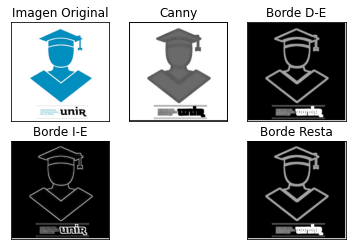

In [11]:
im = cv.cvtColor(im, cv.COLOR_BGR2RGB)
canny = cv.cvtColor(canny, cv.COLOR_BGR2RGB)
plt.subplot(231)
plt.imshow(im)
plt.title('Imagen Original'), plt.xticks([]), plt.yticks([])
plt.subplot(232)
plt.imshow(erosion)
plt.title('Canny'), plt.xticks([]), plt.yticks([])
plt.subplot(233)
plt.imshow(border_d_e)
plt.title('Borde D-E'), plt.xticks([]), plt.yticks([])
plt.subplot(234)
plt.imshow(border_i_e)
plt.title('Borde I-E'), plt.xticks([]), plt.yticks([])
plt.subplot(236)
plt.imshow(border_res)
plt.title('Borde Resta'), plt.xticks([]), plt.yticks([])
plt.show()

Es posible observar que el resultado de restar la erosión a la imagen original es casi identico a los bordes obtenidos con el método de Canny. La ventaja de la operación morfológica radica en el número reducido de pasos que necesarios respecto a Canny, además de que estos son pasos menos complejos.